# Business Objectives:
Our main business objectives are to understand the dynamics of the labour market of Armenia using the online job portal post as a proxy. A secondary objective is to implement advanced text analytics as a proof of concept to create additional features such as enhanced search function that can add additional value to the users of the job portal.

# --------------------------------------------------------------------------------------------------------------

# Importing the Packges

In [2]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize # for tokenization
from nltk.corpus import wordnet # is for word meanings
import nltk.classify.util
# for Sentiement Analysis
from nltk.sentiment.vader import SentimentIntensityAnalyzer
# regex
import re
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer # dtm
from wordcloud import WordCloud ,STOPWORDS # for word cloud
from sklearn.cluster import KMeans # kmeans
from sklearn.feature_extraction.text import TfidfVectorizer # for tf-idf
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm, decomposition, ensemble
from sklearn.linear_model import LogisticRegression # for Logistic Regression
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split # split int train and test
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec 
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

# Impoting the file

In [3]:
job_data  =  pd.read_csv('data job posts.csv')
job_data.head(2)

,jobpost,date,Title,Company,AnnouncementCode,Term,Eligibility,Audience,StartDate,Duration,...,Salary,ApplicationP,OpeningDate,Deadline,Notes,AboutC,Attach,Year,Month,IT
0,AMERIA Investment Consulting Company\nJOB TITL...,"Jan 5, 2004",Chief Financial Officer,AMERIA Investment Consulting Company,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,"To apply for this position, please submit a\nc...",NaN,26 January 2004,NaN,NaN,NaN,2004,1,False
1,International Research & Exchanges Board (IREX...,"Jan 7, 2004",Full-time Community Connections Intern (paid i...,International Research & Exchanges Board (IREX),NaN,NaN,NaN,NaN,NaN,3 months,...,NaN,Please submit a cover letter and resume to:\nI...,NaN,12 January 2004,NaN,The International Research & Exchanges Board (...,NaN,2004,1,False


In [4]:
job_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19001 entries, 0 to 19000
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   jobpost           19001 non-null  object
 1   date              19001 non-null  object
 2   Title             18973 non-null  object
 3   Company           18994 non-null  object
 4   AnnouncementCode  1208 non-null   object
 5   Term              7676 non-null   object
 6   Eligibility       4930 non-null   object
 7   Audience          640 non-null    object
 8   StartDate         9675 non-null   object
 9   Duration          10798 non-null  object
 10  Location          18969 non-null  object
 11  JobDescription    15109 non-null  object
 12  JobRequirment     16479 non-null  object
 13  RequiredQual      18517 non-null  object
 14  Salary            9622 non-null   object
 15  ApplicationP      18941 non-null  object
 16  OpeningDate       18295 non-null  object
 17  Deadline    

In [5]:
# getting the missing values
job_data.isna().sum()

jobpost                 0
date                    0
Title                  28
Company                 7
AnnouncementCode    17793
Term                11325
Eligibility         14071
Audience            18361
StartDate            9326
Duration             8203
Location               32
JobDescription       3892
JobRequirment        2522
RequiredQual          484
Salary               9379
ApplicationP           60
OpeningDate           706
Deadline               65
Notes               16790
AboutC               6531
Attach              17442
Year                    0
Month                   0
IT                      0
dtype: int64

In [6]:
# removed the features with  high missing values.
data=job_data[['jobpost', 'Title', 'Company','JobDescription', 'JobRequirment', 'RequiredQual','AboutC','Year', 'Month', 'IT']]
#

In [7]:
data.isna().sum()
# still have missing values

jobpost              0
Title               28
Company              7
JobDescription    3892
JobRequirment     2522
RequiredQual       484
AboutC            6531
Year                 0
Month                0
IT                   0
dtype: int64

In [8]:
# treating  missing value
cateogry_columns=data.select_dtypes('object').columns
data[cateogry_columns]=data[cateogry_columns].apply(lambda x: x.fillna(x.mode()[0]))
        

In [9]:
data.isna().sum()

jobpost           0
Title             0
Company           0
JobDescription    0
JobRequirment     0
RequiredQual      0
AboutC            0
Year              0
Month             0
IT                0
dtype: int64

In [10]:
# Number of job posts by titles( getting top 20)
top_title = data['Title'].value_counts().nlargest(20).reset_index()
top_title.rename(columns = {'index':'Titles', 'Title': 'Top_postings'} )

,Titles,Top_postings
0,Accountant,356
1,Chief Accountant,219
2,Medical Representative,216
3,Sales Manager,166
4,Administrative Assistant,155
5,Lawyer,151
6,Software Developer,134
7,Project Manager,117
8,English Language Courses,109
9,Web Developer,101


In [11]:
# top company job postings
data.groupby('Company')['jobpost'].count().nlargest(20).reset_index()

,Company,jobpost
0,ArmenTel CJSC,360
1,World Vision Armenia,239
2,Mentor Graphics Development Services CJSC,236
3,Career Center NGO,229
4,Orange Armenia,203
5,Ameriabank CJSC,196
6,Converse Bank CJSC,161
7,SAS Group LLC,150
8,UNDP Armenia Office,132
9,Central Bank of Armenia,126


In [12]:
## Job postings per year
job_posts = pd.DataFrame(data.Year.value_counts().reset_index())
job_posts['Total_Job_Postings'] = job_posts.Year # renaming the cols
job_posts['Year'] = job_posts['index']
job_posts.drop('index', axis=1, inplace=True)
job_posts.sort_values(by='Year', inplace=True)
job_posts

,Year,Total_Job_Postings
11,2004,875
9,2005,1138
10,2006,1116
6,2007,1538
4,2008,1785
8,2009,1191
7,2010,1511
5,2011,1697
0,2012,2149
1,2013,2009


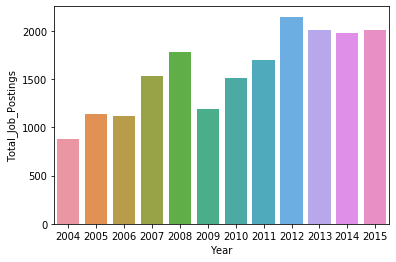

<Figure size 1440x720 with 0 Axes>

In [13]:
sns.barplot(x='Year', y='Total_Job_Postings', data=job_posts)
plt.figure(figsize=(20, 10))
plt.show()

# Top job in each categories (title) from 2004-2015

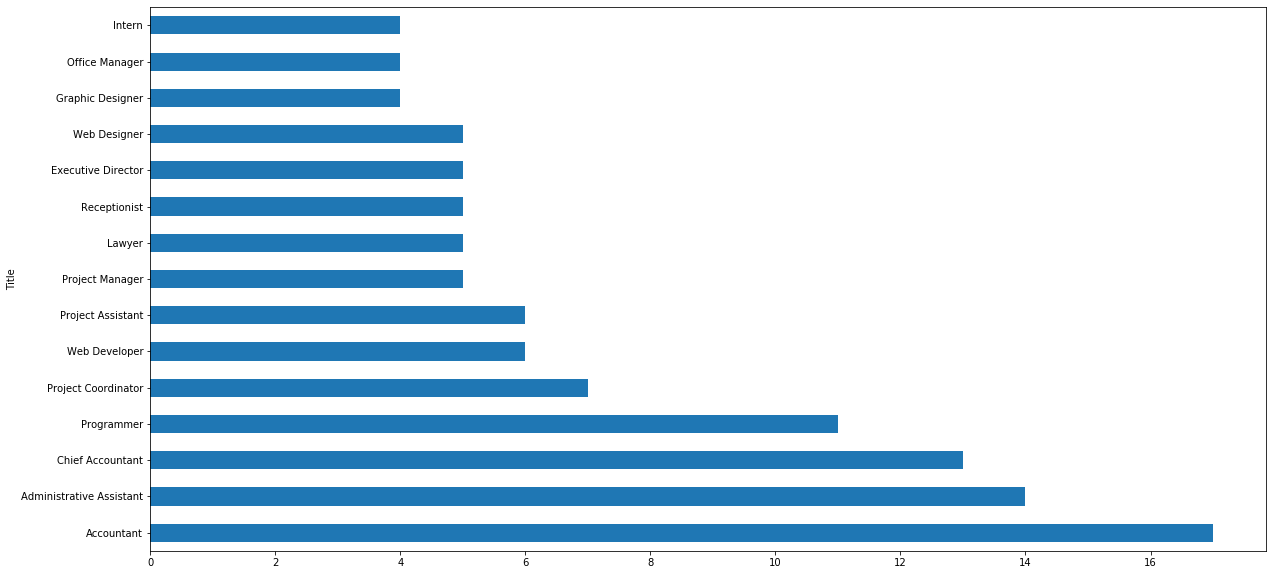

In [14]:
#  for 2004
yr_2004 = data[data.Year == 2004].groupby('Title').count().sort_values(by='jobpost', ascending=False).head(15)
plt.figure(figsize=(20, 10))
yr_2004.jobpost.plot(kind='barh')
plt.show()

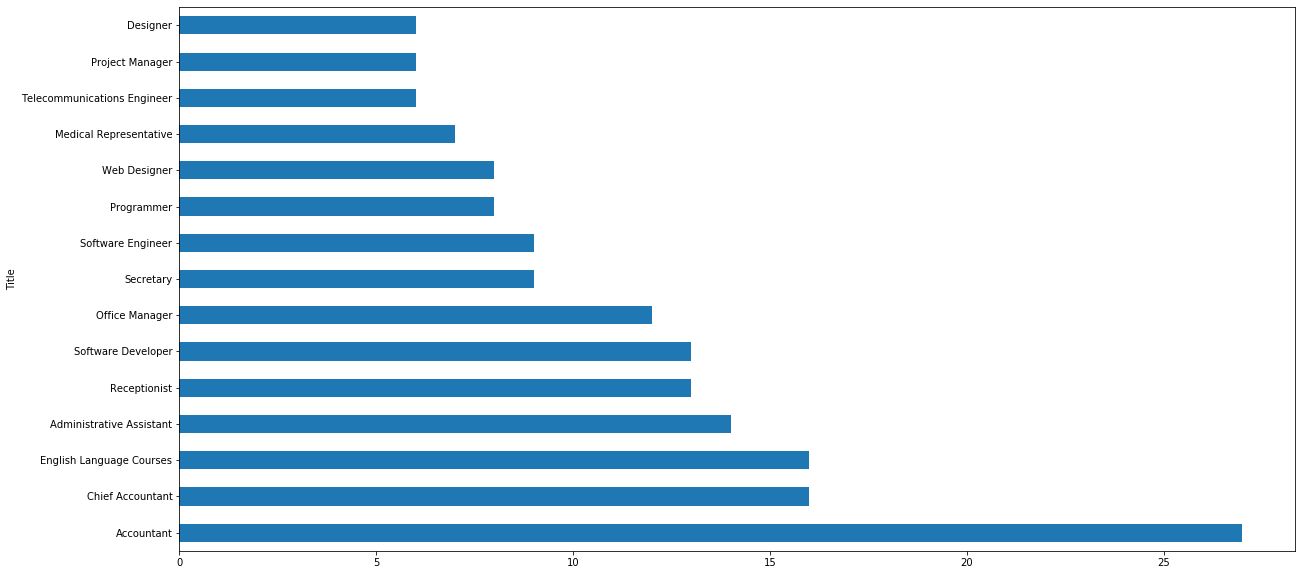

In [15]:
#  for 2005
yr_2005 = data[data.Year == 2005].groupby('Title').count().sort_values(by='jobpost', ascending=False).head(15)
plt.figure(figsize=(20, 10))
yr_2005.jobpost.plot(kind='barh')
plt.show()

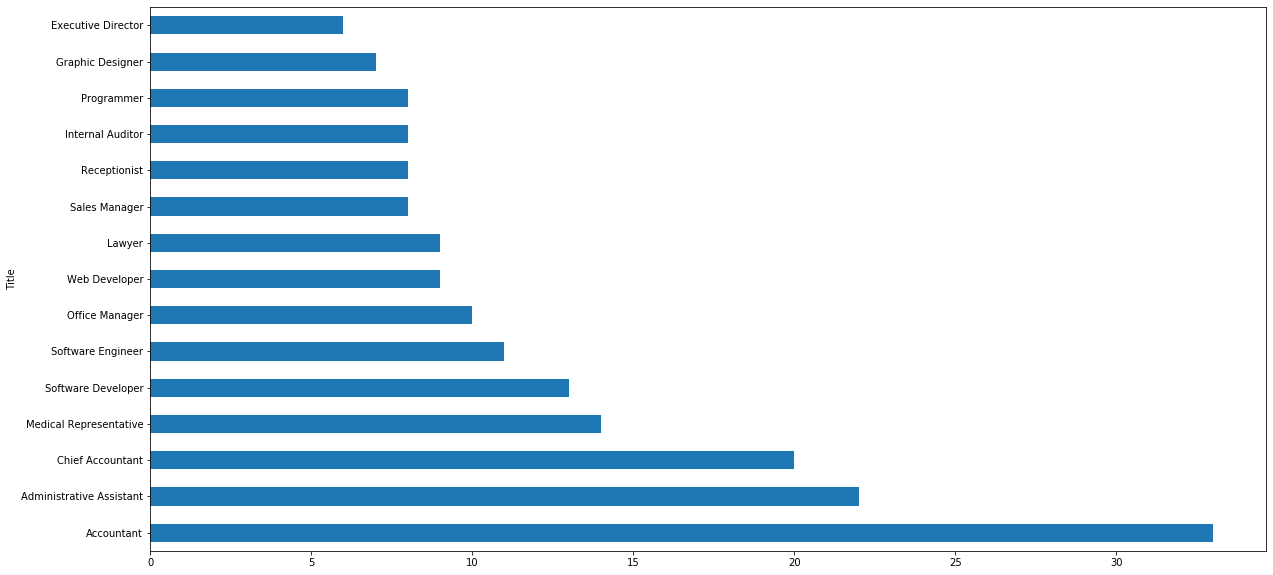

In [16]:
#  for 2006
yr_2006 = data[data.Year == 2006].groupby('Title').count().sort_values(by='jobpost', ascending=False).head(15)
plt.figure(figsize=(20, 10))
yr_2006.jobpost.plot(kind='barh')
plt.show()

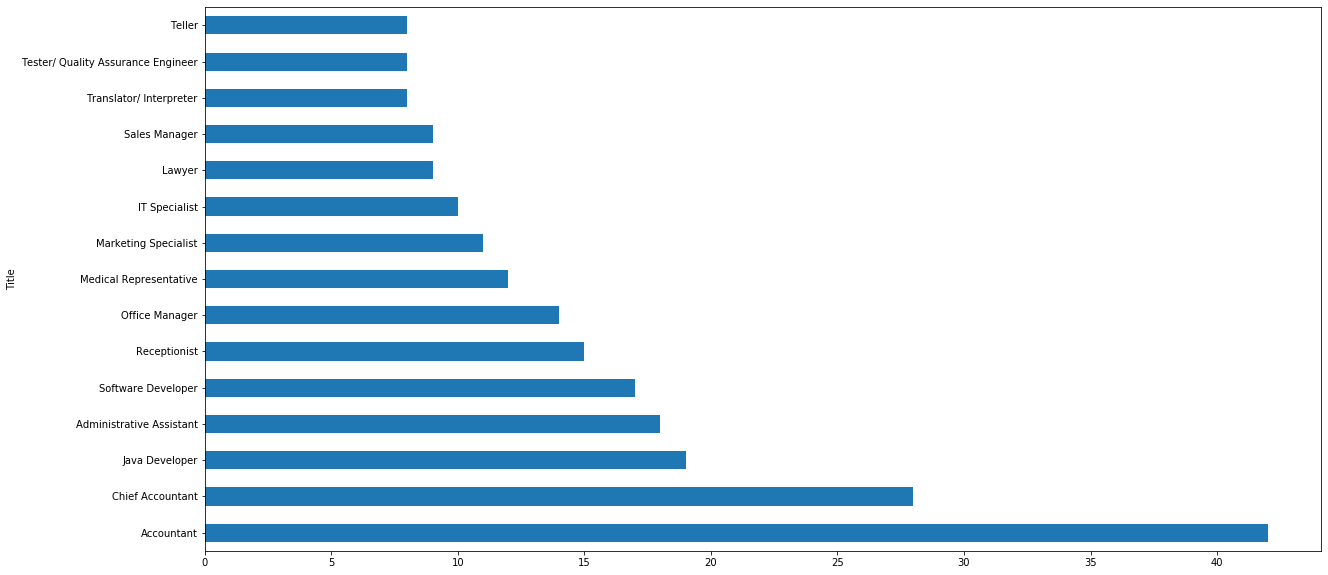

In [17]:
#  for 2007
yr_2007 = data[data.Year == 2007].groupby('Title').count().sort_values(by='jobpost', ascending=False).head(15)
plt.figure(figsize=(20, 10))
yr_2007.jobpost.plot(kind='barh')
plt.show()

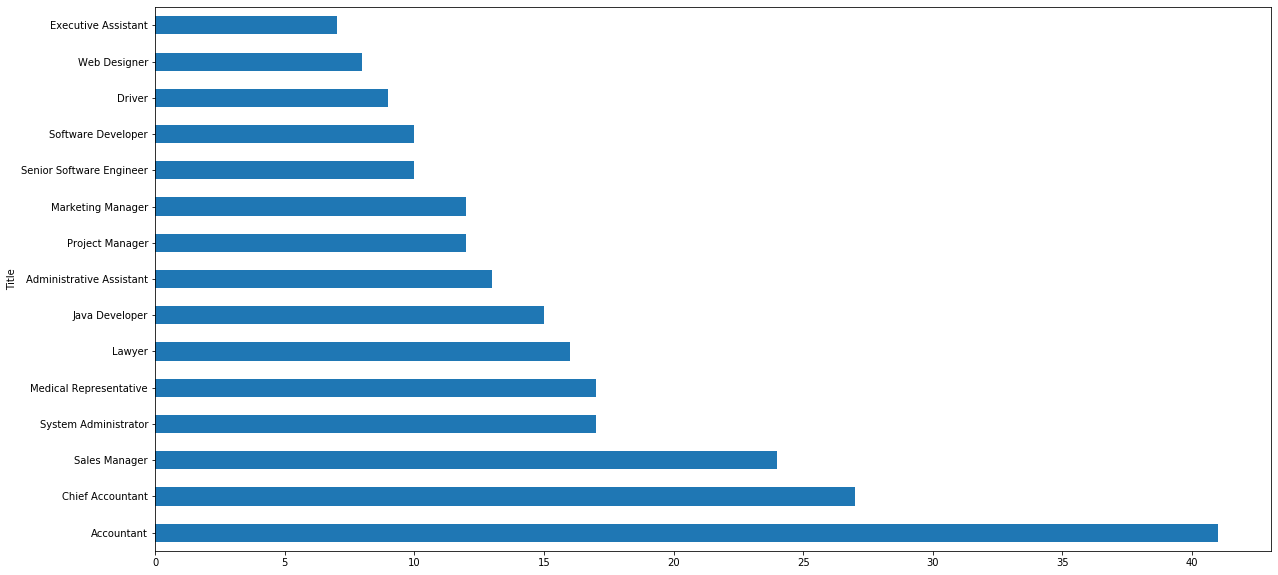

In [18]:
#  for 2008
yr_2008 = data[data.Year == 2008].groupby('Title').count().sort_values(by='jobpost', ascending=False).head(15)
plt.figure(figsize=(20, 10))
yr_2008.jobpost.plot(kind='barh')
plt.show()

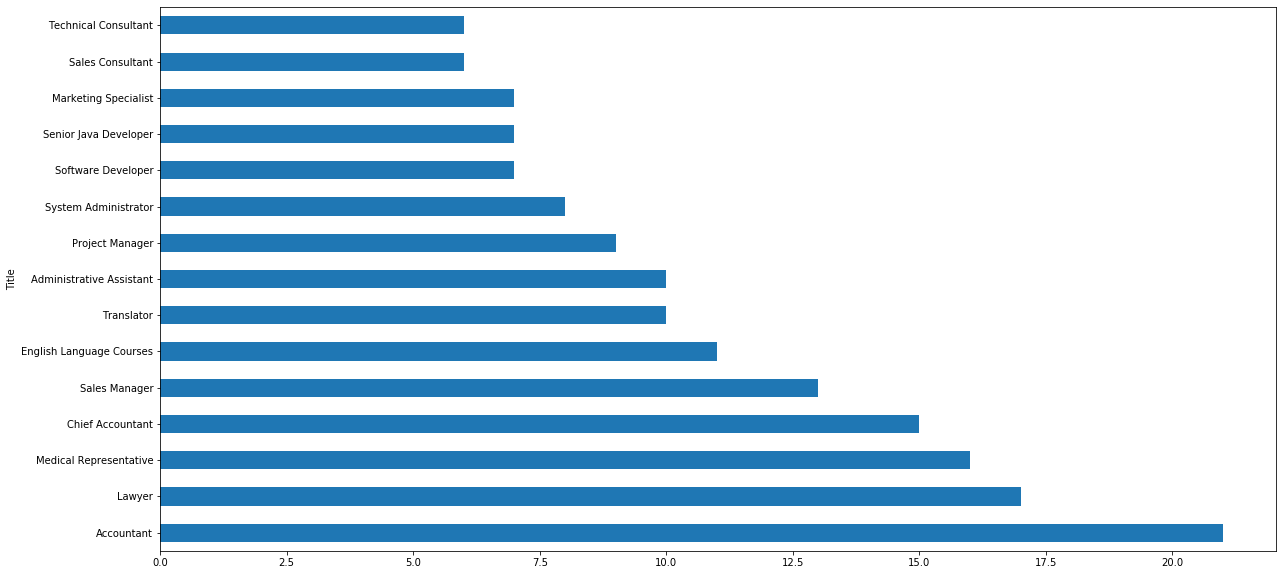

In [19]:
#  for 2009
yr_2009 = data[data.Year == 2009].groupby('Title').count().sort_values(by='jobpost', ascending=False).head(15)
plt.figure(figsize=(20, 10))
yr_2009.jobpost.plot(kind='barh')
plt.show()

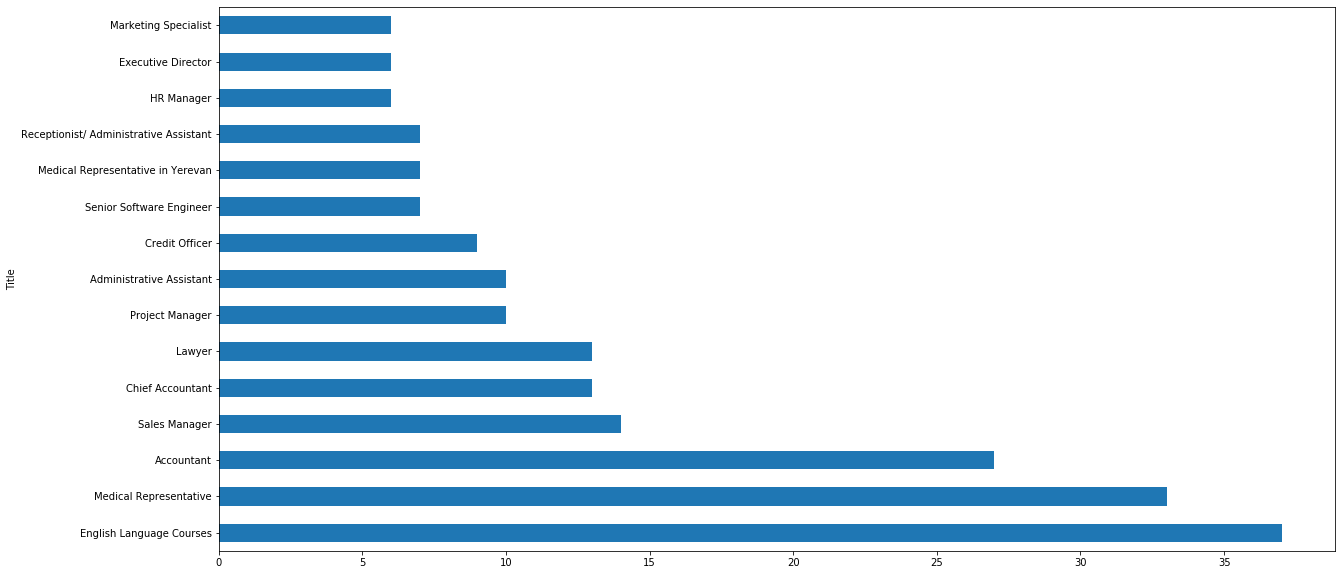

In [20]:
#  for 2010
yr_2010 = data[data.Year == 2010].groupby('Title').count().sort_values(by='jobpost', ascending=False).head(15)
plt.figure(figsize=(20, 10))
yr_2010.jobpost.plot(kind='barh')
plt.show()

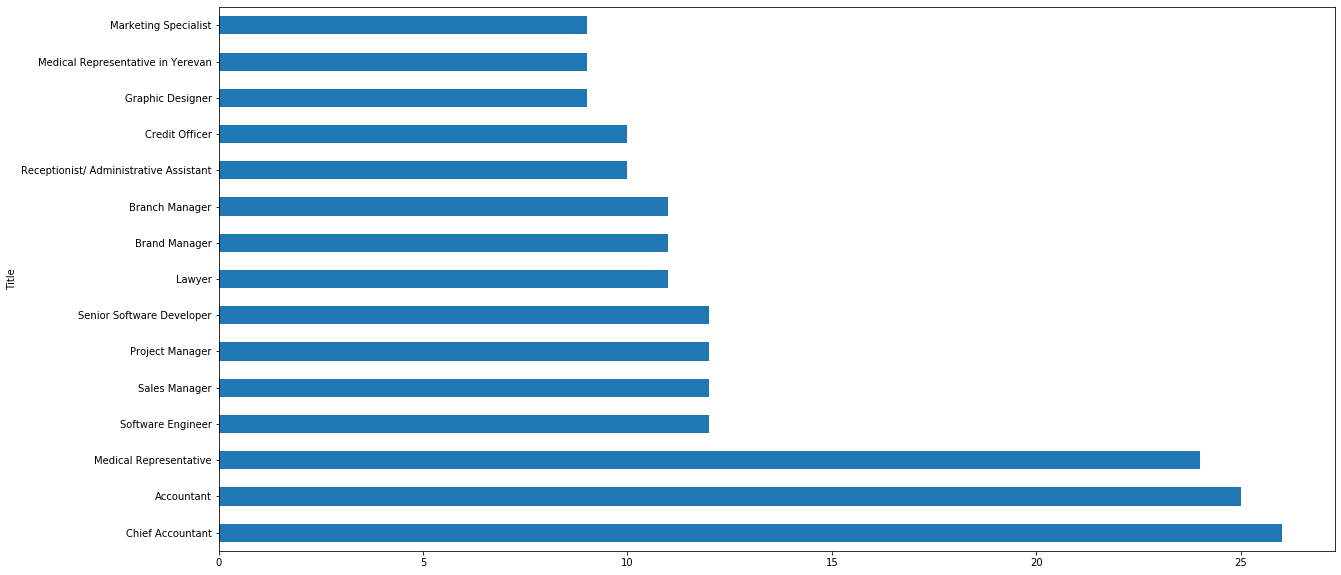

In [21]:
#  for 2011
yr_2011 = data[data.Year == 2011].groupby('Title').count().sort_values(by='jobpost', ascending=False).head(15)
plt.figure(figsize=(20, 10))
yr_2011.jobpost.plot(kind='barh')
plt.show()

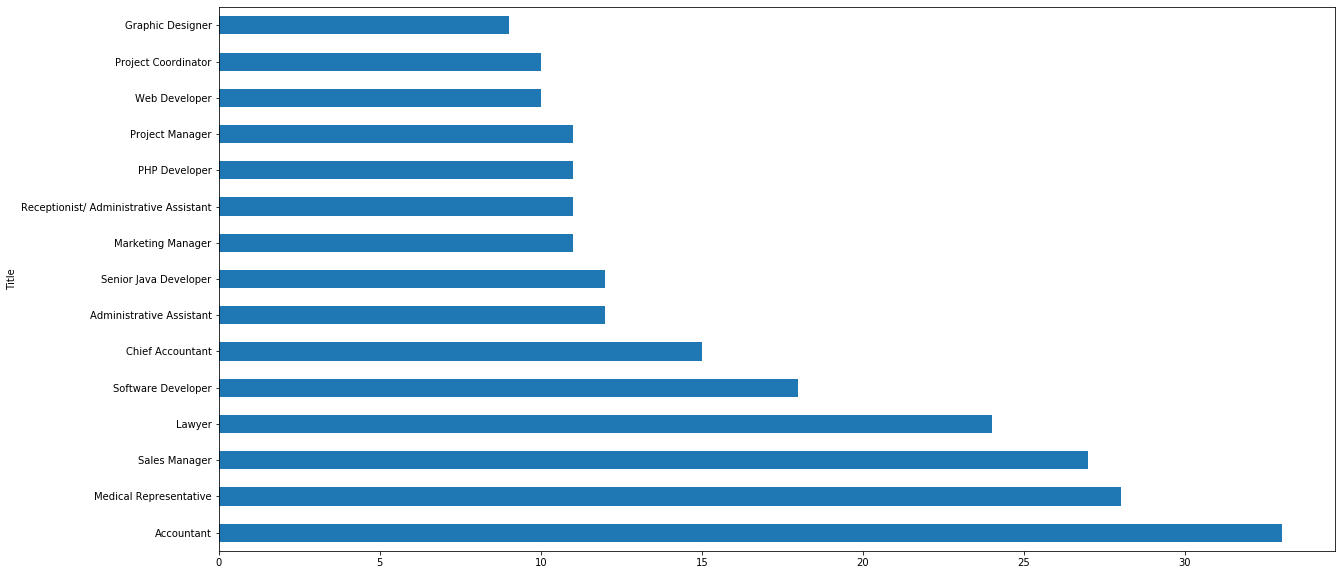

In [22]:
#  for 2012
yr_2012 = data[data.Year == 2012].groupby('Title').count().sort_values(by='jobpost', ascending=False).head(15)
plt.figure(figsize=(20, 10))
yr_2012.jobpost.plot(kind='barh')
plt.show()

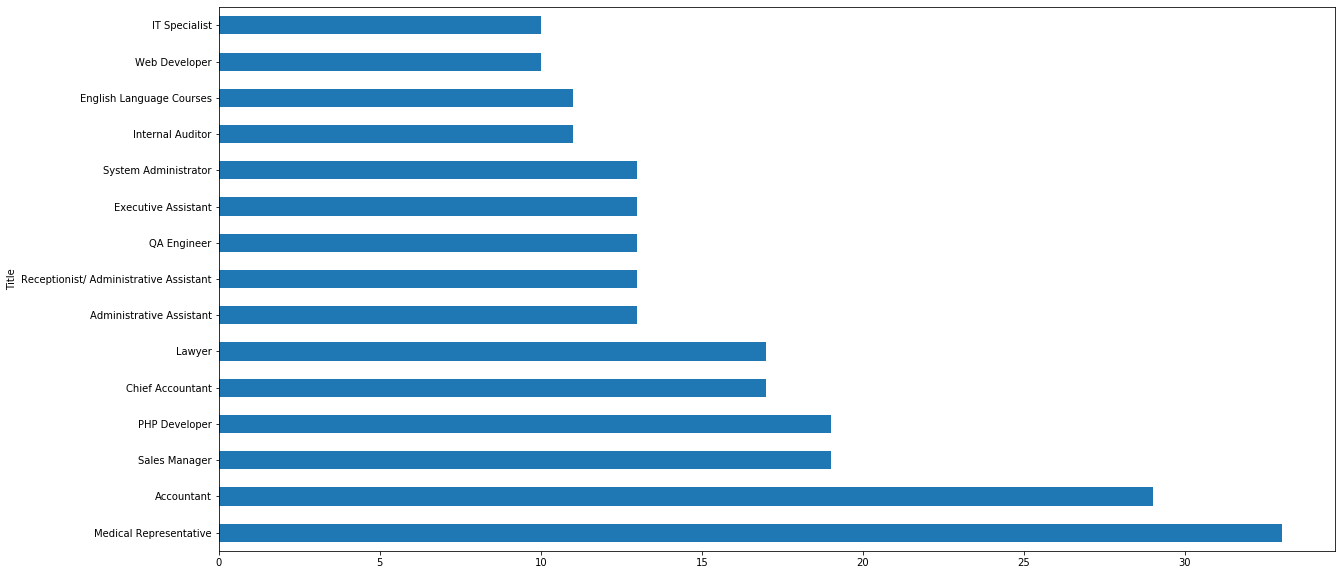

In [23]:
#  for 2013
yr_2013 = data[data.Year == 2013].groupby('Title').count().sort_values(by='jobpost', ascending=False).head(15)
plt.figure(figsize=(20, 10))
yr_2013.jobpost.plot(kind='barh')
plt.show()

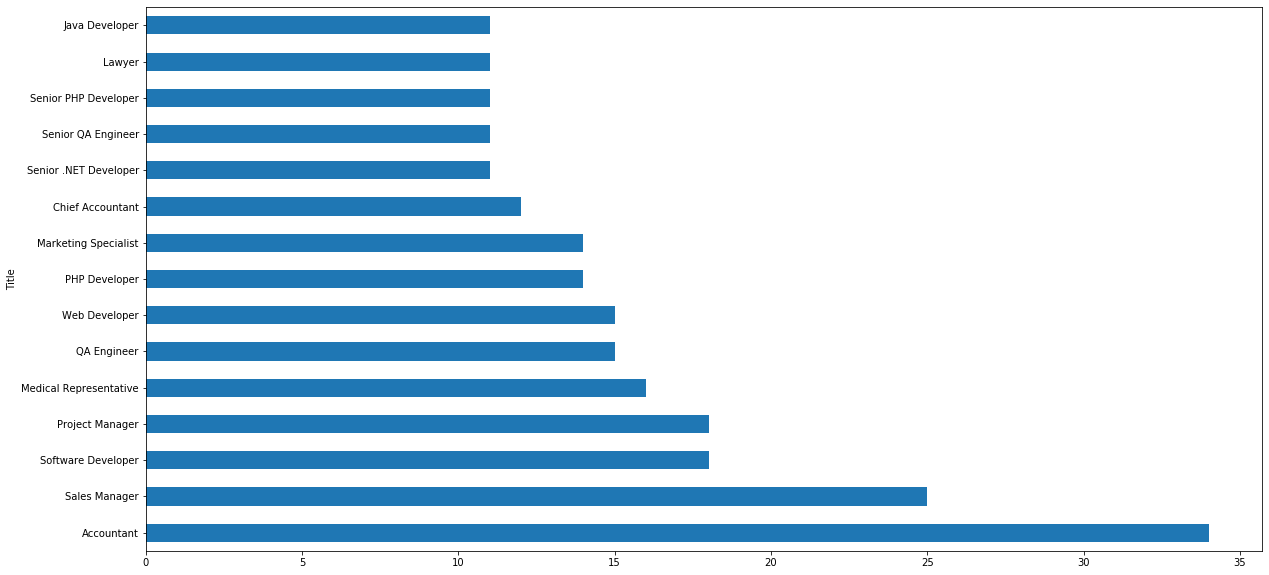

In [24]:
#  for 2014
yr_2014 = data[data.Year == 2014].groupby('Title').count().sort_values(by='jobpost', ascending=False).head(15)
plt.figure(figsize=(20, 10))
yr_2014.jobpost.plot(kind='barh')
plt.show()

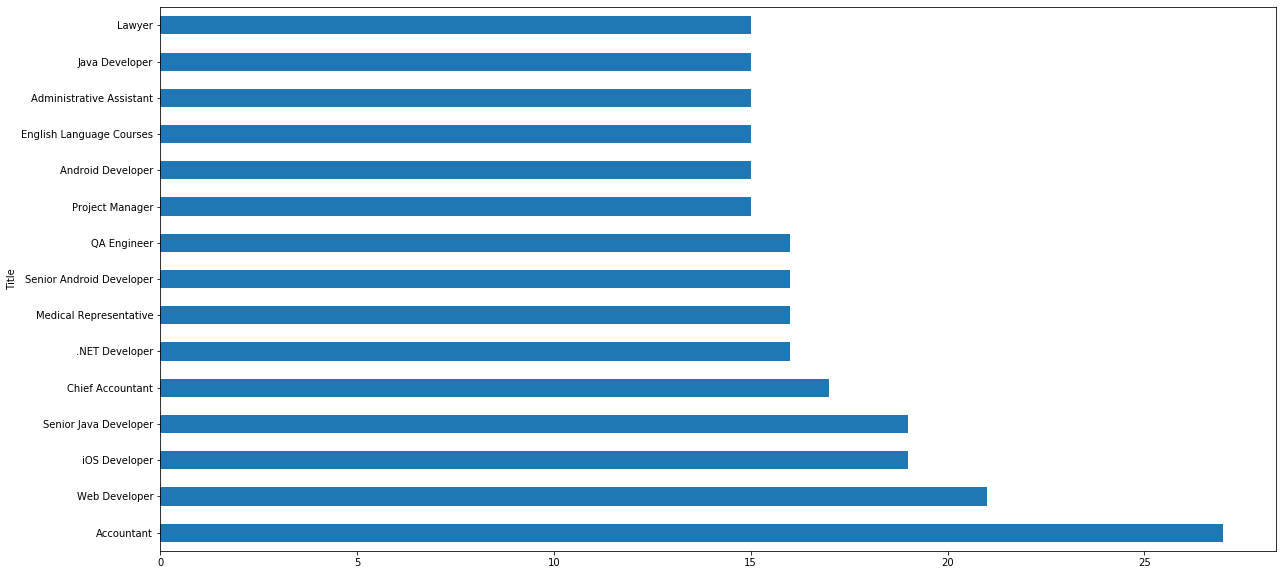

In [26]:
#  for 2015
yr_2015 = data[data.Year == 2015].groupby('Title').count().sort_values(by='jobpost', ascending=False).head(15)
plt.figure(figsize=(20, 10))
yr_2015.jobpost.plot(kind='barh')
plt.show()

### Analysis
- From 2004 to 2009 , there is high demand for the job posting in Accountant.
- In 2010 , the maximum job postings changes to English Language coures
- In 2011, there is high demand for the Cheif Accountant
- In 2012, the job postings for Accountant is maximum.
- In 2013, Medical Representatives have maximum job postings.
- In 2014 and 2015, highest job postings is done in Accountant.

In [27]:
df = data[['RequiredQual', 'IT']]
df.head()

,RequiredQual,IT
0,"To perform this job successfully, an\nindividu...",False
1,- Bachelor's Degree; Master's is preferred;\n-...,False
2,"- Degree in environmentally related field, or ...",False
3,"- Advanced degree in public health, social sci...",False
4,- University degree; economical background is ...,True


In [28]:
from sklearn.preprocessing import LabelEncoder
labelEncoder = LabelEncoder()
df['IT'] = labelEncoder.fit_transform(df['IT'])
df.head()

,RequiredQual,IT
0,"To perform this job successfully, an\nindividu...",0
1,- Bachelor's Degree; Master's is preferred;\n-...,0
2,"- Degree in environmentally related field, or ...",0
3,"- Advanced degree in public health, social sci...",0
4,- University degree; economical background is ...,1


## Calculating Sentiment analysis using Textblob module

In [29]:
df['RequiredQual'] = df['RequiredQual'].astype(str)

In [30]:
df['polarity'] = df["RequiredQual"].apply(lambda x: TextBlob(x).sentiment.polarity)

In [31]:
df.head()

,RequiredQual,IT,polarity
0,"To perform this job successfully, an\nindividu...",0,0.155901
1,- Bachelor's Degree; Master's is preferred;\n-...,0,0.181250
2,"- Degree in environmentally related field, or ...",0,0.080000
3,"- Advanced degree in public health, social sci...",0,0.143704
4,- University degree; economical background is ...,1,0.242857


In [32]:
df['Sentiment']  = np.where(df.polarity == 0,"Neutral",np.where
                                 (df.polarity<0, "Negative","Positive"))
df.head()

,RequiredQual,IT,polarity,Sentiment
0,"To perform this job successfully, an\nindividu...",0,0.155901,Positive
1,- Bachelor's Degree; Master's is preferred;\n-...,0,0.181250,Positive
2,"- Degree in environmentally related field, or ...",0,0.080000,Positive
3,"- Advanced degree in public health, social sci...",0,0.143704,Positive
4,- University degree; economical background is ...,1,0.242857,Positive


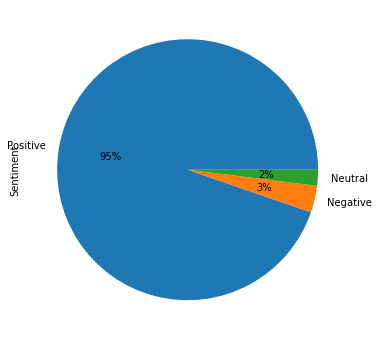

In [33]:
plt.figure(figsize=(12,6))
df['Sentiment'].value_counts().plot(kind='pie', autopct= '%1.0f%%')
plt.show()

## Data Pre-Process

In [34]:
import string

In [35]:
# Text Cleaning
stop = stopwords.words('english') # English Stop words like was, is ,as etc...
def clean_text(text):
    text = text.lower() # Case Standardisation
    text = re.sub(r'[0-9]+', '', text)   #Replacing numbers with none
    text="".join([char for char in text if char not in string.punctuation]) # remove punctuation    
    return text
df['RequiredQual']=df['RequiredQual'].apply(clean_text)
df.head(2)

,RequiredQual,IT,polarity,Sentiment
0,to perform this job successfully an\nindividua...,0,0.155901,Positive
1,bachelors degree masters is preferred\n excel...,0,0.181250,Positive


In [36]:
def remove_newline(text):
    text=re.sub(r'\n', '', text)                           # Replacing the new line with none
    return(text)
df['RequiredQual']=df['RequiredQual'].apply(remove_newline)
df.head(2)

,RequiredQual,IT,polarity,Sentiment
0,to perform this job successfully anindividual ...,0,0.155901,Positive
1,bachelors degree masters is preferred excelle...,0,0.181250,Positive


In [37]:
# english Stopwords
stop  = stopwords.words('english')

In [38]:
# removing stopwords
df['RequiredQual'] = df['RequiredQual'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
df.head(2)

,RequiredQual,IT,polarity,Sentiment
0,perform job successfully anindividual must abl...,0,0.155901,Positive
1,bachelors degree masters preferred excellent s...,0,0.181250,Positive


In [39]:
# Tokenzation
def tokenize(text):
    tokens = re.split('\W+', text)
    return tokens

df['RequiredQual']=df['RequiredQual'].apply(lambda x: tokenize(x))

df.head(2)

,RequiredQual,IT,polarity,Sentiment
0,"[perform, job, successfully, anindividual, mus...",0,0.155901,Positive
1,"[bachelors, degree, masters, preferred, excell...",0,0.181250,Positive


In [40]:
# lemmatization
import nltk
wn=nltk.stem.WordNetLemmatizer()

def lemmatizing(text):
    lemma=[wn.lemmatize(word) for word in text]
    return lemma
df['RequiredQual']=df['RequiredQual'].apply(lambda x:lemmatizing(x))
df.head(2)

,RequiredQual,IT,polarity,Sentiment
0,"[perform, job, successfully, anindividual, mus...",0,0.155901,Positive
1,"[bachelor, degree, master, preferred, excellen...",0,0.181250,Positive


In [41]:
df['RequiredQual'] = df['RequiredQual'].astype(str)

In [42]:
### Define x, y

x = df['RequiredQual']
y = df['IT']

In [43]:
## split int train and test

train_x, test_x, train_y, test_y = train_test_split(x,y,random_state=123,test_size=0.3)

In [44]:
## Vectorization (TF_IDF) of train and test
#train

tfidf_vect = TfidfVectorizer(analyzer='word', 
                             token_pattern=r'\w{1,}', 
                             ngram_range=(1, 1 ), 
                             min_df=5, 
                             encoding='latin-1' , 
                             lowercase = True,
                             max_features=1000)
X_train_tfidf = tfidf_vect.fit_transform(train_x)

#test
X_test_tfidf = tfidf_vect.transform(test_x)

In [45]:
TF_TDF=pd.DataFrame(X_train_tfidf.toarray(), columns=tfidf_vect.get_feature_names())
TF_TDF.head()

,abilitiesmay,ability,able,abroad,academic,acca,accept,accepted,access,according,...,would,write,writing,written,x,xhtml,xml,xp,year,yerevan
0,0.0,0.213476,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.042216,0.0
1,0.0,0.086039,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.134593,0.0,0.0,0.0,0.0,0.000000,0.0
2,0.0,0.208915,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.065362,0.0,0.0,0.0,0.0,0.041314,0.0
3,0.0,0.067794,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.067034,0.0
4,0.0,0.086039,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.134593,0.0,0.0,0.0,0.0,0.000000,0.0


# Superviesd Learning

In [46]:
# Using logistic regression
# fitting the model
log=LogisticRegression()
log.fit(X_train_tfidf,train_y)

LogisticRegression()

In [47]:
 # getting the accuracy

train_accuracy=metrics.accuracy_score(train_y, log.predict(X_train_tfidf))
test_accuracy=metrics.accuracy_score(test_y, log.predict(X_test_tfidf))

print("train_accuracy:", train_accuracy)
print("test_accuracy:", test_accuracy)

train_accuracy: 0.9320300751879699
test_accuracy: 0.9251008594983336


In [48]:
# getting roc_auc_score
train_roc_auc = metrics.roc_auc_score(train_y, log.predict(X_train_tfidf))
print('Roc Auc Score of training dataset: ', train_roc_auc)

test_roc_auc = metrics.roc_auc_score(test_y, log.predict(X_test_tfidf))
print('Roc Auc Score of testing dataset: ', test_roc_auc)

Roc Auc Score of training dataset:  0.869085336020946
Roc Auc Score of testing dataset:  0.8536906977895022


In [49]:
# using rondom Forest
from sklearn.ensemble import RandomForestClassifier

In [50]:
RF = RandomForestClassifier()
RF.fit(X_train_tfidf,train_y)

RandomForestClassifier()

In [51]:
# Accuracy
y_pred = RF.predict(X_train_tfidf)
acc_RF = metrics.accuracy_score(train_y, y_pred)
acc_RF

0.9978195488721805

# Unsupervised (K means)

In [52]:
df['RequiredQual'] = df['RequiredQual'].astype(str)
df1 = df[['RequiredQual']]
df1.head()

,RequiredQual
0,"['perform', 'job', 'successfully', 'anindividu..."
1,"['bachelor', 'degree', 'master', 'preferred', ..."
2,"['degree', 'environmentally', 'related', 'fiel..."
3,"['advanced', 'degree', 'public', 'health', 'so..."
4,"['university', 'degree', 'economical', 'backgr..."


In [53]:
def remove_punctuations(text):
    text=re.sub(r'!"#$%&()*,-./:;<=>?@\[]^_`{|}~','', text)                
    text=text.lower()                                       
    return(text)

df1['RequiredQual']=df1['RequiredQual'].apply( lambda x: remove_punctuations(x))
df1['RequiredQual'].head(4)

0    ['perform', 'job', 'successfully', 'anindividu...
1    ['bachelor', 'degree', 'master', 'preferred', ...
2    ['degree', 'environmentally', 'related', 'fiel...
3    ['advanced', 'degree', 'public', 'health', 'so...
Name: RequiredQual, dtype: object

In [54]:
# tfidf
vectorizer = TfidfVectorizer(min_df = 0.1, max_df=0.9,
                             ngram_range=(1, 4), 
                             stop_words='english')
vectorizer.fit(df1['RequiredQual'])

TfidfVectorizer(max_df=0.9, min_df=0.1, ngram_range=(1, 4),
                stop_words='english')

In [55]:
train_x = vectorizer.transform(df1['RequiredQual'])
vocab=vectorizer.get_feature_names()[:10]
vocab

['ability',
 'ability work',
 'ability work pressure',
 'accounting',
 'advanced',
 'analytical',
 'application',
 'armenian',
 'armenian russian',
 'basic']

In [56]:
# k mean model
# going for 6 cluster solution
model = KMeans(n_clusters=6, init='k-means++', max_iter=100, n_init=1,random_state=5)
res = model.fit(train_x)
res

KMeans(max_iter=100, n_clusters=6, n_init=1, random_state=5)

In [57]:
vocab = vectorizer.get_feature_names()
vocab = np.array(vocab)


In [58]:
# getting the centroids and feature
cluster_centers = res.cluster_centers_.argsort()[:, ::-1]
features=vectorizer.get_feature_names()

In [59]:
sorted_vals = [res.cluster_centers_[i].argsort() for i in range(0,np.shape(res.cluster_centers_)[0])]

In [60]:
words=set()
for i in range(len(res.cluster_centers_)):
    words = words.union(set(vocab[sorted_vals[i][-10:]]))
    print(words)

{'design', 'year', 'knowledge', 'good', 'development', 'ability', 'strong', 'software', 'skill', 'experience'}
{'design', 'year', 'higher education', 'education', 'skill', 'experience', 'excellent', 'language', 'knowledge', 'good', 'higher', 'development', 'russian', 'ability', 'strong', 'software', 'work'}
{'design', 'year', 'higher education', 'education', 'management', 'skill', 'experience', 'university degree', 'excellent', 'language', 'knowledge', 'degree', 'good', 'university', 'higher', 'development', 'russian', 'ability', 'strong', 'english', 'software', 'work'}
{'design', 'year', 'higher education', 'accounting', 'armenian', 'good knowledge', 'education', 'management', 'skill', 'experience', 'university degree', 'excellent', 'language', 'knowledge', 'degree', 'good', 'university', 'higher', 'development', 'russian', 'ability', 'strong', 'english', 'software', 'work'}
{'design', 'year', 'higher education', 'accounting', 'knowledge russian', 'oral', 'armenian', 'good knowledge',

In [61]:
words= list(words)

In [62]:
df1['cluster'] = model.labels_
df1.groupby('cluster').count()

,RequiredQual
cluster,
0,3293
1,3055
2,4636
3,3222
4,581
5,4214


In [63]:
df1.head()

,RequiredQual,cluster
0,"['perform', 'job', 'successfully', 'anindividu...",3
1,"['bachelor', 'degree', 'master', 'preferred', ...",5
2,"['degree', 'environmentally', 'related', 'fiel...",2
3,"['advanced', 'degree', 'public', 'health', 'so...",0
4,"['university', 'degree', 'economical', 'backgr...",3


# Topic Modelling

In [64]:
# train a LDA Model
lda_model = decomposition.LatentDirichletAllocation(n_components=20, learning_method='online', max_iter=20)
X_topics = lda_model.fit_transform(X_train_tfidf)
topic_word = lda_model.components_ 
vocab = tfidf_vect.get_feature_names()

In [65]:
# view the topic models
n_top_words = 10
topic_summaries = []
for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
    topic_summaries.append(' '.join(topic_words))

topic_summaries

['math physic desired designing educational previous preferred radio military phd',
 'accounting knowledge finance tax legislation law ra standard armenian software',
 'food digital specialization water abroad specialist yerevan across region aspect',
 'network system knowledge window engineering technical electrical administration unix experience',
 'autocad custom friendly outside small armenianlanguages report ra analyzing spoken',
 'knowledge education higher russian language relevant experience field english armenian',
 'express ability adaptable learner efficiently fast supervision proper passionate work',
 'adobe photoshop draw corel illustrator graphic design profound workexperience central',
 'testing tool test qa scripting knowledge assurance quality experience automation',
 'c knowledge experience development programming good software design science skill',
 'skill ability knowledge work experience excellent strong management communication armenian',
 'skill knowledge work e